# Test GPU

In [1]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [2]:
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10779944869808954491, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11317166080
 locality {
   bus_id: 1
 }
 incarnation: 837744144062303422
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"]

In [3]:
get_available_gpus()

['/gpu:0']

In [4]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


# Start

In [5]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [15]:
train_labels.shape, valid_labels.shape, test_labels.shape

((230070, 6), (5684, 6), (13068, 6))

In [20]:
train_dataset.shape, valid_dataset.shape, test_dataset.shape

((230070, 32, 32, 1), (5684, 32, 32, 1), (13068, 32, 32, 1))

In [7]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.subtract(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in range(0, kernel_shape[2]):
        for i in range(0, kernel_shape[0]):
            for j in range(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [8]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [10]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]

# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# S2: sub-sampling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# S4: sub-sampling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]

    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))

    tf.summary.scalar("loss", loss)

    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
    valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
    test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])

    saver = tf.train.Saver()

In [13]:
with tf.Session(graph=graph) as session:
    saver.restore(session, "CNN_multi.ckpt")

INFO:tensorflow:Restoring parameters from CNN_multi.ckpt
None


In [13]:
writer = tf.summary.FileWriter('Graph', graph=graph)


num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()  
    #   reader = tf.train.NewCheckpointReader("CNN_multi.ckpt")
    #   reader.get_variable_to_shape_map()
    saver.restore(session, "CNN_multi.ckpt")
    print("Model restored.")  

    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 500 == 0): 
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
        print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
        
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, "CNN_multi.ckpt")
    print("Model saved in file: %s" % save_path)

INFO:tensorflow:Restoring parameters from CNN_multi.ckpt
Model restored.
Initialized
Minibatch loss at step 0: 0.711818
Minibatch accuracy: 97.2%
Validation accuracy: 93.4%


KeyboardInterrupt: 

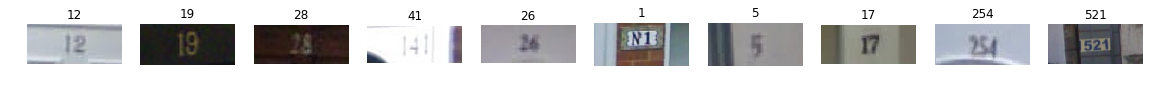

In [13]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

ValueError: slice index 5 of dimension 0 out of bounds. for 'strided_slice_15' (op: 'StridedSlice') with input shapes: [5,13068,11], [2], [2], [2] and with computed input tensors: input[1] = <5 0>, input[2] = <6 0>, input[3] = <1 1>.

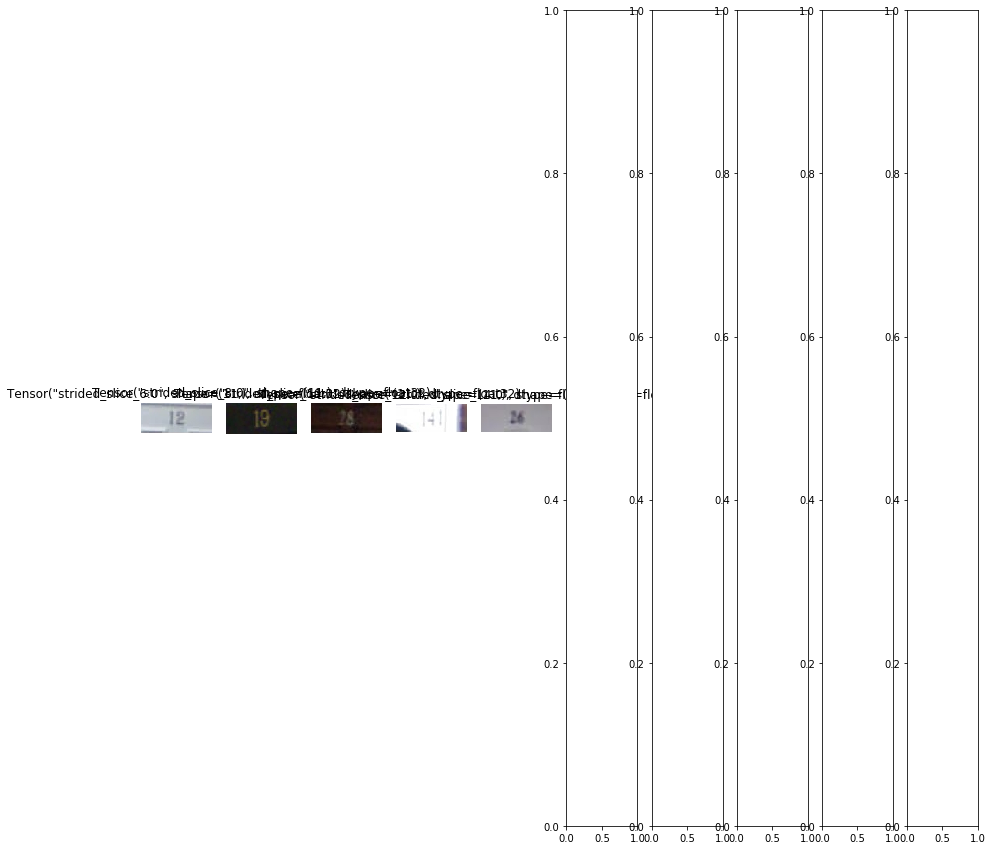

In [14]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)